# Classifier comparison script from documentation
Modified the code from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html, scikit learn documentation, in a similar way to https://github.com/dataprofessor/code/blob/master/python/comparing-classifiers.ipynb.

In [20]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import pickle
from sklearn.model_selection import GridSearchCV

RANDOM_STATE = 1

In [139]:
names = ["Nearest_Neighbors", "Linear_SVM", "Polynomial_SVM", "RBF_SVM", "Gaussian_Process",
         "Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest", "Neural_Net", "AdaBoost",
         "Naive_Bayes", "QDA", "SGD"]
RANDOM_STATE = 1

classifiers = [
    KNeighborsClassifier(n_neighbors = 32, p=2, weights='uniform'),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="poly", degree=3, C=0.025),
    SVC(kernel="rbf", C=1, gamma=2),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
    RandomForestClassifier(random_state=RANDOM_STATE),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(loss="hinge", penalty="l2")]

In [95]:
def import_and_split_data_1():
    # import data into groups of 3 and give labels according to the groups of 10
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = train_time_series.to_numpy()
    test_X = test_time_series.to_numpy()

    # assume change of activity cannot be instananeous and copy over label in groups of 10
    train_Y = np.zeros(train_X.shape[0])
    test_Y = np.zeros(test_X.shape[0])
    
    for i in range(len(train_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        train_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
    
    for i in range(len(test_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        test_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
    

    # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [ ]:
def import_and_split_data_10():
    # import data such that each group of 10 for which a label is provided is grouped into a single row
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = np.zeros((len(train_labels['label']), 30))
    for i in range(len(train_labels['label'])):
        first_index = 10*i
        last_index = first_index + 10
        train_X[i][0:10] = train_time_series['x'].iloc[first_index:last_index].to_numpy()
        train_X[i][10:20] = train_time_series['y'].iloc[first_index:last_index].to_numpy()
        train_X[i][20:30] = train_time_series['z'].iloc[first_index:last_index].to_numpy()

    test_X = np.zeros((len(test_labels['label']), 30))
    for i in range(len(test_labels['label'])):
        first_index = 10*i
        last_index = first_index + 10
        test_X[i][0:10] = test_time_series['x'].iloc[first_index:last_index].to_numpy()
        test_X[i][10:20] = test_time_series['y'].iloc[first_index:last_index].to_numpy()
        test_X[i][20:30] = test_time_series['z'].iloc[first_index:last_index].to_numpy()

    train_Y = train_labels['label'].to_numpy()
    test_Y = test_labels['label'].to_numpy()

    # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [106]:
def import_and_split_data_3_window():
    # import data into groups of 3 and give labels according to the groups of 10
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = train_time_series.to_numpy()
    test_X = test_time_series.to_numpy()

    # assume change of activity cannot be instananeous and copy over label in groups of 10
    train_Y = np.zeros(train_X.shape[0])
    test_Y = np.zeros(test_X.shape[0])
    
    for i in range(len(train_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        train_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
    
    for i in range(len(test_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        test_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
        
    # copy x y z from one time step before and after
    train_X = np.concatenate((train_X[1:-1,:],train_X[0:-2],train_X[2:]),axis=1) # horizontally
    train_Y = train_Y[1:-1]
    

    # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [119]:
def import_and_split_data_5_window():
    # import data into groups of 3 and give labels according to the groups of 10
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = train_time_series.to_numpy()
    test_X = test_time_series.to_numpy()

    # assume change of activity cannot be instananeous and copy over label in groups of 10
    train_Y = np.zeros(train_X.shape[0])
    test_Y = np.zeros(test_X.shape[0])
    
    for i in range(len(train_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        train_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
    
    for i in range(len(test_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        test_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
        
    # copy x y z from two time steps before and after
    train_X = np.concatenate((train_X[2:-2,:],train_X[1:-3,:],train_X[0:-4,:],train_X[3:-1,:],train_X[4:,:]),axis=1) # horizontally
    train_Y = train_Y[2:-2]
    

    # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [129]:
def import_and_split_data_9_window():
    # import data into groups of 3 and give labels according to the groups of 10
    train_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_labels.csv',index_col=0)
    train_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/train_time_series.csv',index_col=0)
    test_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_labels.csv',index_col=0)
    test_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/test_time_series.csv',index_col=0)

    # remove first four entires in training set
    train_labels = train_labels.iloc[1:, :]
    train_time_series = train_time_series.iloc[4:,:]

    # pop off unecassary features
    train_time_series.pop('accuracy')
    test_time_series.pop('accuracy')

    train_time_series.pop('UTC time')
    test_time_series.pop('UTC time')

    train_time_series.pop('timestamp')
    test_time_series.pop('timestamp')

    # normalise accelerometer readings
    train_time_series[['x','y','z']] = (train_time_series[['x','y','z']] - train_time_series[['x','y','z']].mean())/(train_time_series[['x','y','z']].max() - train_time_series[['x','y','z']].min())
    test_time_series[['x','y','z']] = (test_time_series[['x','y','z']] - test_time_series[['x','y','z']].mean())/(test_time_series[['x','y','z']].max() - test_time_series[['x','y','z']].min())

    # organise into numpy array for training
    train_X = train_time_series.to_numpy()
    test_X = test_time_series.to_numpy()

    # assume change of activity cannot be instananeous and copy over label in groups of 10
    train_Y = np.zeros(train_X.shape[0])
    test_Y = np.zeros(test_X.shape[0])
    
    for i in range(len(train_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        train_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
    
    for i in range(len(test_labels['label'])):
        first_index = i*10
        second_index = first_index+10
        test_Y[first_index:second_index] = np.ones(10) * (train_labels['label'].iloc[i])
        
    # copy x y z from two time steps before and after
    train_X = np.concatenate((train_X[4:-4,:],
                              train_X[0:-8,:],
                              train_X[1:-7,:],
                              train_X[2:-6,:],
                              train_X[3:-5,:],
                              train_X[5:-3,:],
                              train_X[6:-2,:],
                              train_X[7:-1,:],
                              train_X[8:,:])
                             ,axis=1) # horizontally
    train_Y = train_Y[4:-4]
    

    # split train_X into training and validation sets
    train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y,random_state=RANDOM_STATE)
        # use random_state=1 to have the same training/validation split across different runs
    
    return train_X, val_X, test_X, train_Y, val_Y

In [78]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_1()

In [40]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_10()

In [107]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_3_window()

In [120]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_5_window()

In [130]:
RANDOM_STATE =1
X_train, X_val, X_test, Y_train, Y_val = import_and_split_data_9_window()

In [131]:
X_train.shape

(2799, 27)

In [140]:
scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, Y_train)
    score = clf.score(X_val, Y_val)
    scores.append(score)

In [141]:
import pandas as pd
import seaborn as sns

In [142]:
df = pd.DataFrame()
df['name'] = names
df['score'] = scores
df

,name,score
0,Nearest_Neighbors,0.743837
1,Linear_SVM,0.579850
2,Polynomial_SVM,0.579850
3,RBF_SVM,0.741693
4,Gaussian_Process,0.785638
5,Gradient_Boosting,0.754555
6,Decision_Tree,0.634512
7,Extra_Trees,0.757771
8,Random_Forest,0.790997
9,Neural_Net,0.603430


In [143]:
#https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

cm = sns.light_palette("green", as_cmap=True)
s = df.style.background_gradient(cmap=cm)
s

,name,score
0,Nearest_Neighbors,0.743837
1,Linear_SVM,0.579850
2,Polynomial_SVM,0.579850
3,RBF_SVM,0.741693
4,Gaussian_Process,0.785638
5,Gradient_Boosting,0.754555
6,Decision_Tree,0.634512
7,Extra_Trees,0.757771
8,Random_Forest,0.790997
9,Neural_Net,0.603430


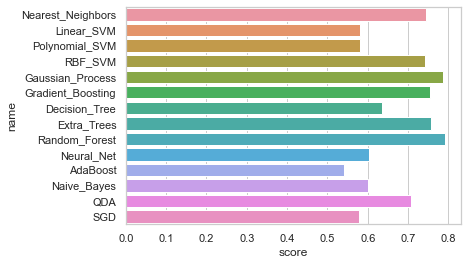

In [144]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=df)

In [145]:
training_scores = []
for name, clf in zip(names, classifiers):
    training_score = clf.score(X_train, Y_train)
    training_scores.append(training_score)

df = pd.DataFrame()
df['name'] = names
df['training scores'] = training_scores
cm = sns.light_palette("green", as_cmap=True)
s = df.style.background_gradient(cmap=cm)
s

,name,training scores
0,Nearest_Neighbors,0.744194
1,Linear_SVM,0.567703
2,Polynomial_SVM,0.567703
3,RBF_SVM,0.752769
4,Gaussian_Process,0.888889
5,Gradient_Boosting,1.000000
6,Decision_Tree,0.667381
7,Extra_Trees,1.000000
8,Random_Forest,1.000000
9,Neural_Net,0.611290


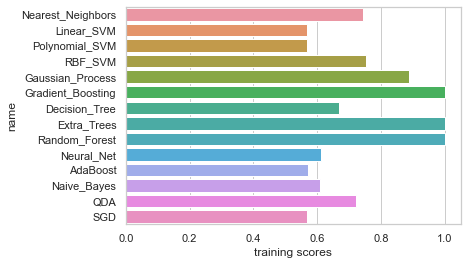

In [146]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="training scores", data=df)